In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
dataset_type = {
    "vtab/flowers": "natural",
    "cars": "natural",
    "vtab/svhn": "natural",
    "fer2013": "natural",
    "renderedsst2": "natural",
    "mnist": "natural",
    "vtab/pets": "natural",
    "vtab/caltech101": "natural",
    "vtab/cifar100": "natural",
    "voc2007_multilabel": "natural",
    "imagenet1k": "natural",
    "imagenetv2": "natural",
    "imagenet-a": "natural",
    "imagenet-o": "natural",
    "imagenet-r": "natural",
    "objectnet": "natural",
    "voc2007": "natural",
    "sun397": "natural",
    "fgvc_aircraft": "natural",
    "country211": "natural",
    "vtab/cifar10": "natural",
    "vtab/dtd": "natural",
    "gtsrb": "natural",
    "stl10": "natural",

    "vtab/diabetic_retinopathy": "specialized",
    "imagenet_sketch": "specialized",
    "vtab/eurosat": "specialized",
    "vtab/resisc45": "specialized",
    "vtab/pcam": "specialized",

    "vtab/clevr_count_all": "structured",
    "vtab/dsprites_label_orientation": "structured",
    "vtab/clevr_closest_object_distance": "structured",
    "vtab/smallnorb_label_elevation": "structured",
    "vtab/dmlab": "structured",
    "vtab/kitti_closest_vehicle_distance": "structured",
    "vtab/dsprites_label_x_position": "structured",
    "vtab/smallnorb_label_azimuth": "structured",


}
def extract_arch(model):
    vit, size, patch_size, *rest = model.split("-")
    return vit+"-"+size+"-"+patch_size


/p/software/jurecadc/stages/2020/software/Jupyter/2021.3.2-gcccoremkl-10.3.0-2021.2.0-Python-3.8.5/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("benchmark.csv")
df.loc[:, "dataset_type"] = df.dataset.apply(lambda d:dataset_type[d])
df.loc[:, "model_arch"] = df.model.apply(extract_arch)

# Accuracy of all models on all datasets

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

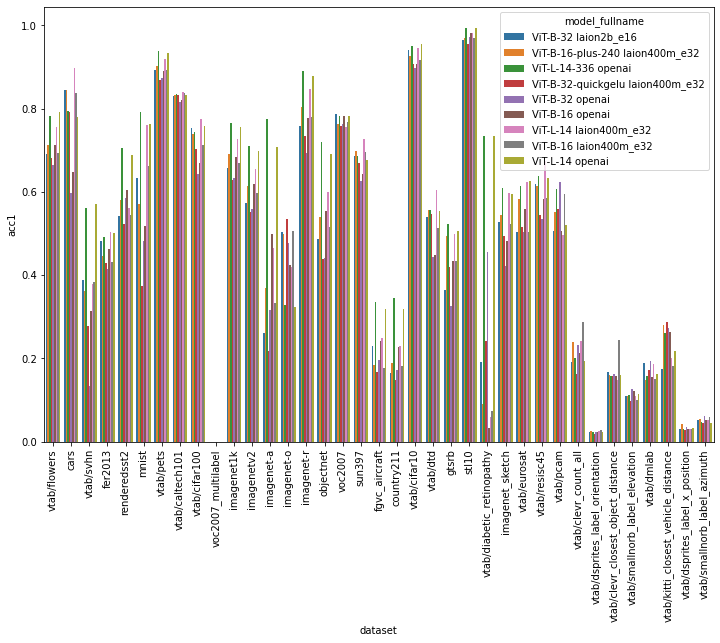

In [3]:
fig = plt.figure(figsize=(12,8))
#order = df.sort_values(by="dataset_type").dataset.unique()
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Zoomig on a specific architecture

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

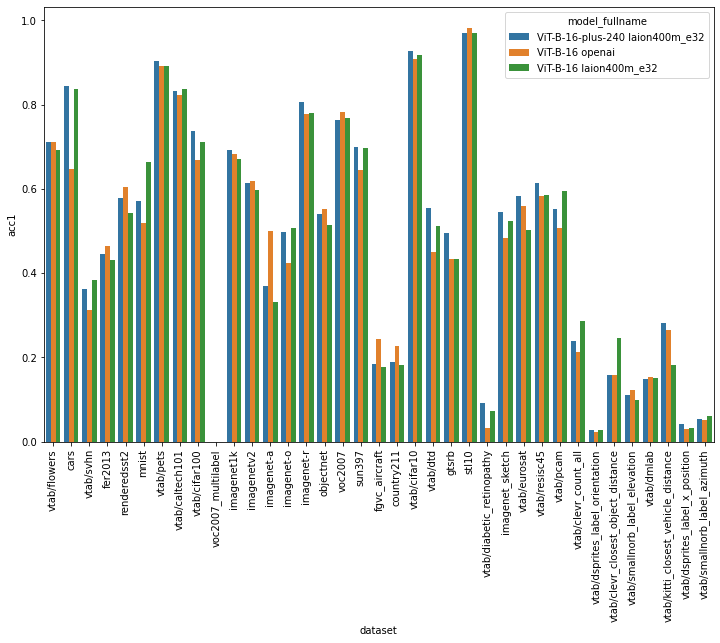

In [4]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df[df.model_arch=="ViT-B-16"]
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Accuracy averaged over all models for each dataset

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

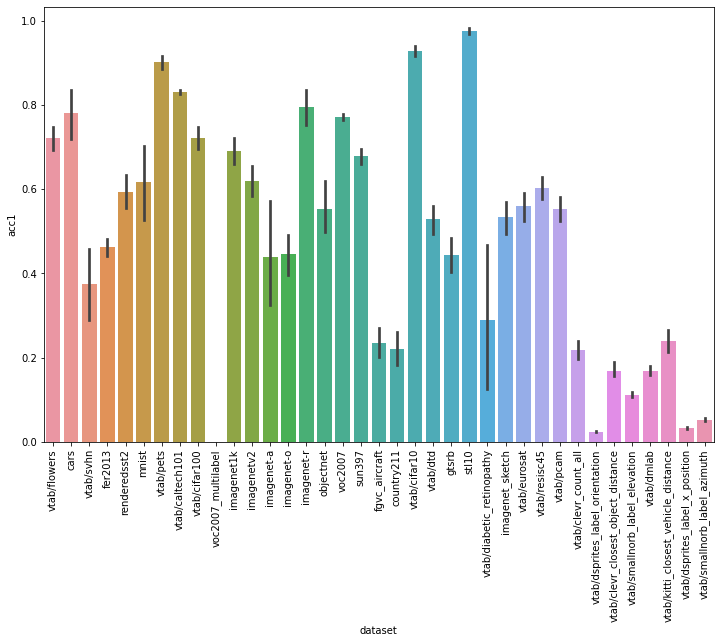

In [5]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", data=df,
    order=order
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over architecture for each dataset

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

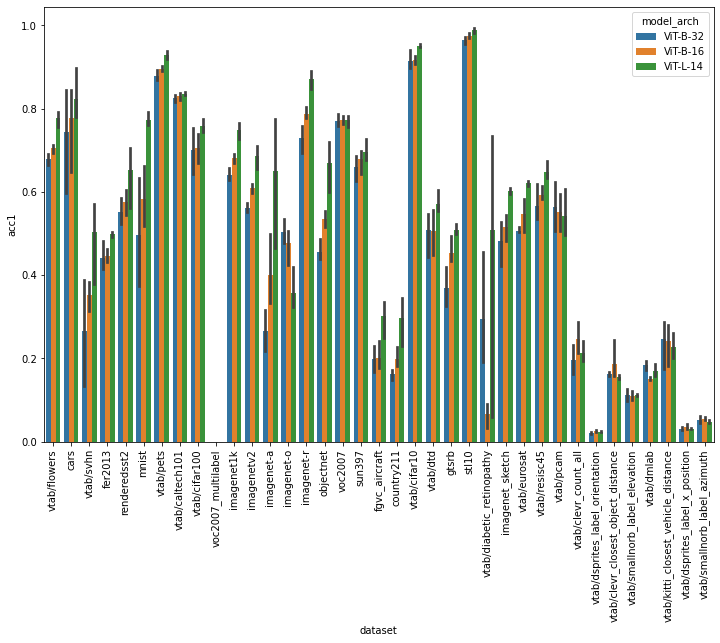

In [6]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_arch"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over pre-training data source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

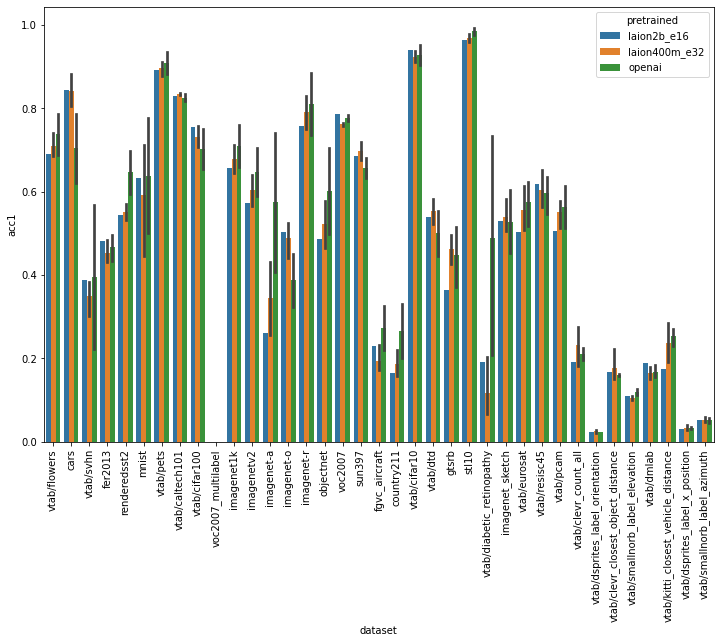

In [7]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Best results from each pre-training source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

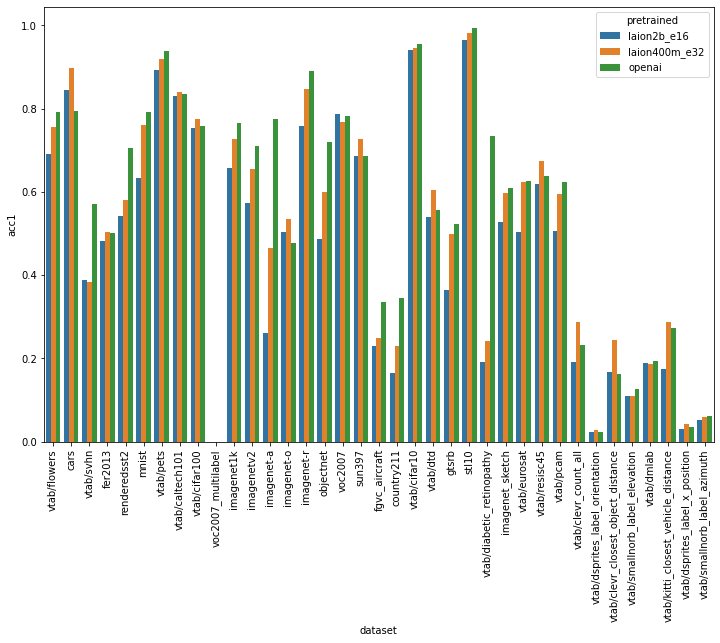

In [8]:
fig = plt.figure(figsize=(12,8))
order = list(dataset_type.keys())
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained",
    estimator=np.max,
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Detailed results

### All results (acc1)

In [9]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai
dataset,,,,,,,,,
cars,0.837,0.647,0.845,0.844,0.596,0.793,0.896,0.779,0.794
country211,0.181,0.228,0.189,0.165,0.172,0.148,0.230,0.319,0.345
fer2013,0.432,0.463,0.445,0.481,0.414,0.430,0.503,0.501,0.491
fgvc_aircraft,0.177,0.243,0.185,0.231,0.196,0.167,0.250,0.318,0.335
gtsrb,0.435,0.433,0.494,0.365,0.326,0.420,0.499,0.506,0.524
imagenet-a,0.332,0.499,0.369,0.261,0.316,0.217,0.465,0.708,0.775
imagenet-o,0.507,0.423,0.498,0.502,0.477,0.534,0.419,0.323,0.328
imagenet-r,0.779,0.777,0.805,0.759,0.694,0.734,0.847,0.879,0.891
imagenet1k,0.670,0.683,0.692,0.657,0.633,0.629,0.728,0.756,0.766


### Imagenet robustness results (acc1)

In [10]:
# Imagenet robustness results
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric[(df_metric.index.str.startswith("imagenet")) | (df_metric.index=="objectnet")]

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai
dataset,,,,,,,,,
imagenet-a,0.332,0.499,0.369,0.261,0.316,0.217,0.465,0.708,0.775
imagenet-o,0.507,0.423,0.498,0.502,0.477,0.534,0.419,0.323,0.328
imagenet-r,0.779,0.777,0.805,0.759,0.694,0.734,0.847,0.879,0.891
imagenet1k,0.670,0.683,0.692,0.657,0.633,0.629,0.728,0.756,0.766
imagenet_sketch,0.524,0.482,0.544,0.529,0.423,0.494,0.596,0.596,0.610
imagenetv2,0.596,0.619,0.615,0.574,0.559,0.551,0.654,0.698,0.709
objectnet,0.515,0.553,0.539,0.487,0.442,0.439,0.599,0.690,0.720


# Robustness plot

Here, following "Measuring Robustness to Natural Distribution Shifts
in Image Classification" (https://arxiv.org/pdf/2007.00644.pdf, https://share.streamlit.io/modestyachts/imagenet-testbed-website/main/website.py),
we show  the deviation from the line fit of (x=imagenet1k accuracy, y=imagenetv2/imagenet-1/imagenet_sketch) which was used
to measure robustnest improvements separately from accuracy improvements in imagenet1k, as the two are correlated.

In the plot below, deviation from the line are improvements in robustness.

No handles with labels found to put in legend.


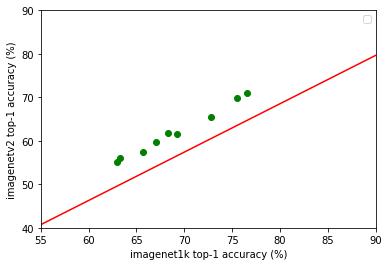

In [11]:
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values="acc1").T.dropna()
dataset = "imagenetv2"
line_fits_data = {
    # slopes and intercepts from https://share.streamlit.io/modestyachts/imagenet-testbed-website/main/website.py
    "imagenetv2": (1.112, -20.433),
    "imagenet-r": (1.549, -104.556),
    "imagenet_sketch": (0.931, -45.373)
}
x=np.linspace(0, 100,100)
slope, intercept = line_fits_data[dataset]
y=x*slope+intercept
plt.xlim(55,90)
plt.ylim(40,90)
d = df_metric.T[["imagenet1k", dataset]]*100
plt.scatter(d["imagenet1k"], d[dataset], color="green")
plt.plot(x,y, color="red")
plt.xlabel("imagenet1k top-1 accuracy (%)")
plt.ylabel(f"{dataset} top-1 accuracy (%)")
plt.legend()

### All results (mean_per_class_recall)

In [12]:
metric = "mean_per_class_recall"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai
dataset,,,,,,,,,
cars,0.838,0.647,0.845,0.844,0.597,0.795,0.896,0.779,0.794
country211,0.181,0.228,0.189,0.165,0.172,0.148,0.230,0.319,0.345
fer2013,0.391,0.418,0.395,0.463,0.364,0.398,0.451,0.494,0.496
fgvc_aircraft,0.177,0.242,0.185,0.230,0.196,0.167,0.249,0.318,0.335
gtsrb,0.404,0.364,0.430,0.343,0.305,0.389,0.449,0.439,0.453
imagenet-a,0.340,0.483,0.382,0.284,0.328,0.235,0.471,0.678,0.736
imagenet-o,0.516,0.438,0.510,0.513,0.490,0.539,0.435,0.326,0.332
imagenet-r,0.765,0.761,0.791,0.744,0.680,0.720,0.832,0.865,0.877
imagenet1k,0.670,0.683,0.692,0.657,0.633,0.629,0.728,0.755,0.766


### All results (mAP)

In [13]:
# For multi-label classification tasks
metric = "mean_average_precision"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 laion2b_e16,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32,ViT-L-14 laion400m_e32,ViT-L-14 openai,ViT-L-14-336 openai
dataset,,,,,,,,,
voc2007_multilabel,0.784,0.789,0.784,0.793,0.760,0.763,0.785,0.790,0.804


## Aggregating over datasets

See VTAB (https://arxiv.org/pdf/1910.04867.pdf, Section E) for a discussion about different aggregation 
strategies and how much they correlate. They find that all aggregation strategies have high
Kendall score with the simple top-1 mean accuracy over datasets.

### Ranking the models over mean top-1 accuracy over all datasets

In [14]:
df.groupby("model_fullname").agg(['mean', 'std', 'median']).sort_values(by=("acc1", "mean"), ascending=False)

acc1               acc5               \
                                  mean   std median  mean   std median   
model_fullname                                                           
ViT-L-14-336 openai              0.561 0.285  0.626 0.820 0.238  0.926   
ViT-L-14 openai                  0.551 0.285  0.630 0.816 0.238  0.914   
ViT-L-14 laion400m_e32           0.515 0.293  0.578 0.800 0.239  0.892   
ViT-B-16-plus-240 laion400m_e32  0.493 0.279  0.548 0.780 0.245  0.860   
ViT-B-16 laion400m_e32           0.484 0.277  0.514 0.780 0.242  0.866   
ViT-B-32 laion2b_e16             0.480 0.278  0.505 0.779 0.246  0.847   
ViT-B-16 openai                  0.474 0.270  0.503 0.782 0.231  0.860   
ViT-B-32-quickgelu laion400m_e32 0.458 0.271  0.504 0.760 0.250  0.858   
ViT-B-32 openai                  0.455 0.256  0.466 0.765 0.235  0.851   

                                 mean_per_class_recall               \
                                                  mean   std median   
model_fullname                                                        
ViT-L-14-336 openai                              0.552 0.290  0.620   
ViT-L-14 openai                                  0.544 0.289  0.618   
ViT-L-14 laion400m_e32                           0.520 0.292  0.573   
ViT-B-16-plus-240 laion400m_e32                  0.501 0.277  0.548   
ViT-B-16 laion400m_e32                           0.488 0.275  0.515   
ViT-B-32 laion2b_e16                             0.486 0.276  0.512   
ViT-B-16 openai                                  0.481 0.264  0.495   
ViT-B-32-quickgelu laion400m_e32                 0.461 0.273  0.509   
ViT-B-32 openai                                  0.452 0.262  0.460   

                                 mean_average_precision             
                                                   mean std median  
model_fullname                                                      
ViT-L-14-336 openai                               0.804 nan  0.804  
ViT-L-14 openai                                   0.790 nan  0.790  
ViT-L-14 laion400m_e32                            0.785 nan  0.785  
ViT-B-16-plus-240 laion400m_e32                   0.784 nan  0.784  
ViT-B-16 laion400m_e32                            0.784 nan  0.784  
ViT-B-32 laion2b_e16                              0.793 nan  0.793  
ViT-B-16 openai                                   0.789 nan  0.789  
ViT-B-32-quickgelu laion400m_e32                  0.763 nan  0.763  
ViT-B-32 openai                                   0.760 nan  0.760

### Compute rank of the model for each dataset (1 = best, lower is better), then average the ranks over the datasets

In [15]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric.rank(axis=1,ascending=False).agg(["mean", "std"]).T.sort_values(by="mean",ascending=True)

,mean,std
ViT-L-14-336 openai,2.917,2.156
ViT-L-14 openai,3.417,2.247
ViT-L-14 laion400m_e32,3.819,2.502
ViT-B-16-plus-240 laion400m_e32,4.625,1.683
ViT-B-16 laion400m_e32,5.208,2.163
ViT-B-32 laion2b_e16,5.694,2.112
ViT-B-16 openai,5.764,1.907
ViT-B-32 openai,6.306,2.896
ViT-B-32-quickgelu laion400m_e32,7.250,2.234
